# Emerging Topics final code - Pandemics

This code was created from Martha and Sean's emerging topic code and was used to create the hottest/coldest topics static graphics for the full, pandemics, and coronavirus corpora.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns

/home/kjl5t/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Data Ingestion

In [3]:
# full corpus
#df = pd.read_pickle("../../data/final/final_dataset_7-20.pkl")

# pandemic corpus
df = pd.read_pickle("../../data/prd/JSM21/pandemic_corpus.pkl")
df.reset_index(inplace=True)

# coronavirus corpus -- NEED TO CREATE
#df = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/corona_corpus.pkl")
#df.reset_index(inplace=True)

In [4]:
df.head()

,level_0,index,original index,PROJECT_ID,ABSTRACT,FY,ORG_COUNT,PI_COUNT,working_abstract,Start_Char,nchar,LAST_CHAR,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens,final_frqwds_removed,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
0,355,355,174965,583520,Since the 1960s Tennessee has been a leader in...,2008,1,1,Since the 1960s Tennessee has been a leader in...,S,3165,y,"[1960, Tennessee, leader, development, adoptio...","[1960, tennessee, leader, development, adoptio...","[1960, tennessee, leader, development, adoptio...","[1960, tennessee, leader, development, adoptio...","[1960, tennessee, leader, development, adoptio...","[1960, tennessee, leader, adoption, conservati...",Active Learning; Adoption; Agriculture; AIDS/...,COLLABORATIVE RESEARCH WITH THE NATIONAL UNIVE...,USDA,NIFA,NaN,2008-51160-04373,5/15/2008,1/14/2009,"WALKER, FORBES R","EASH, NEAL",02,133891015,UNIVERSITY OF TENNESSEE,KNOXVILLE,TN,37996-4540,UNITED STATES,NaN,NaN,10.212,2008,95987.0,NaN
1,759,759,1001252,1101260,Rapidly spreading Zika virus (ZIKV) is an emer...,2017,1,1,Rapidly spreading Zika virus (ZIKV) is an emer...,R,3561,y,"[rapidly, spread, Zika, virus, ZIKV, emerge, z...","[rapidly, spread, zika, virus, zikv, emerge, z...","[rapidly, spread, zika, virus, zikv, emerge, z...","[rapidly, spread, zika_virus_zikv, emerge, zoo...","[rapidly, spread, zika_virus_zikv, emerge, zoo...","[rapidly, spread, zika_virus_zikv, emerge, zoo...",Adult; Aedes; Africa; Americas; Antibodies; A...,NEW LIVE ATTENUATED ZIKA VIRUS VACCINE,DOD,CDMRP,NaN,PR172269,7/15/2018,1/14/2020,"ZENG, MINGTAO",NaN,19,609980727,TEXAS TECH UNIVERSITY HEALTH SCIENCES CENTER,EL PASO,TX,79905,UNITED STATES,NaN,NaN,12.420,2017,305997.0,NaN
2,767,767,1001101,1101109,Topic Area: InfluenzaArea of Emphasis: Develop...,2017,1,1,Topic Area: InfluenzaArea of Emphasis: Develop...,T,4219,y,"[topic, area, InfluenzaArea, emphasis, develop...","[topic, area, influenzaarea, emphasis, develop...","[topic, area, influenzaarea, emphasis, develop...","[topic, area, influenzaarea, emphasis, develop...","[topic, area, influenzaarea, emphasis, develop...","[topic, influenzaarea, emphasis, evaluation, i...",Adaptive Immune System; Address; Adjuvant; ae...,"APPLICATION OF AN IMMUNE-MODULATING, ANTI-INFL...",DOD,CDMRP,NaN,PR170327,7/15/2018,1/14/2020,"SIEGEL, HAL",NaN,06,080294428,NEW AMSTERDAM SCIENCES,SCOTTSDALE,AZ,85260,UNITED STATES,NaN,NaN,12.420,2017,204046.0,NaN
3,1873,1873,441317,813151,Objective(s): The safety of aquaculture produc...,2011,1,1,"The safety of aquaculture products, particular...",T,4679,s,"[safety, aquaculture, product, particularly, m...","[safety, aquaculture, product, particularly, m...","[safety, aquaculture, product, particularly, m...","[safety, aquaculture, product, particularly, m...","[safety, aquaculture, product, particularly, m...","[safety, aquaculture, product, particularly, m...",Affect; Algae; Aquaculture; Bacteriophages; B...,PATHOGEN DETECTION AND INTERVENTION METHODS FO...,USDA,ARS,NaN,ARS-0420935,1/31/2011,1/30/2016,"RICHARDS, GARY P",NaN,13,NaN,AGRICULTURAL RESEARCH SERVICE,WYNDMOOR,PA,19038,UNITED STATES,NaN,NaN,10.001,2011,865694.0,NaN
4,1949,1949,165262,270537,This subproject is one of many research subpro...,2008,1,1,Synthesis of a new type of potential influenza...,S,92,d,"[synthesis, new, type, potential, influenza, i...","[synthesis, new, type, potential, influenza, i...","[synthesis, new, type, potential, influenza, i...","[synthesis, new, type, potential, influenza, i...","[synthesis, new, type, potential, influenza, i...","[synthesis, influenza, inhibitor, alter, immun...",Computer Retrieval of Information on Scientif...,"INFLUEN

In [5]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_frqwds_removed"]

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [6]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [7]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14
- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 30, random_state = 1

In [8]:
# use for full dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = tfidf_vectorizer.fit_transform(text)

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False)
tf_idf = tfidf_vectorizer.fit_transform(text)


In [9]:
# create model

num_topics = 30 

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 2.7309441566467285


In [10]:
print_topics(topic_term, tfidf_vectorizer, 20)


Topic 0:
('influenza', 4.574812096153582)
('strain', 0.5428464205696146)
('virus', 0.5018039239681942)
('antigenic', 0.23883933431496)
('vaccination', 0.1903502687942482)
('public', 0.16838814404258068)
('death', 0.15553683162811294)
('infection', 0.14288648436113116)
('immunity', 0.1399765012847084)
('health', 0.13755801931789893)
('dr', 0.12890764678541303)
('related', 0.11990610223171388)
('annual', 0.11305842018863842)
('universal', 0.10770989375183389)
('morbidity_mortality', 0.10110012515602727)
('season', 0.09669069318769617)
('ctl', 0.09322208211346253)
('burden', 0.09200442696272775)
('infant', 0.08921128272440056)
('hemagglutinin_ha_neuraminidase_na', 0.08625255741831812)

Topic 1:
('hiv', 2.5535099115423123)
('aids', 0.3910516136047347)
('infect', 0.23223827984344228)
('infection', 0.19255102088568066)
('prevention', 0.13765672639760843)
('antiretroviral', 0.13115324237666037)
('transmission', 0.12606529499320437)
('art', 0.11853011307490591)
('individual', 0.11813057692084

### Emerging Topics

In [10]:
# Extract Year from PROJECT_START_DATE

#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [11]:
sum(df['PROJECT_START_DATE'].isna())

0

In [12]:
df['START_YEAR'].value_counts(dropna=False)

2009    299
2011    286
2010    274
2012    237
2008    220
2016    199
2014    196
2015    192
2017    176
2018    169
2019    161
2013    156
2007    133
2006     66
2003     52
2005     41
2004     31
2001     19
1999     15
2002     14
1998      9
1997      8
1993      8
1990      6
1991      5
2000      5
1983      4
1987      4
1992      3
1981      3
1977      3
1994      3
1989      3
1996      2
1995      1
2020      1
1980      1
1979      1
Name: START_YEAR, dtype: int64

In [13]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


#### compute count of projects with weight > 0 for each topic

In [14]:
topic_proj_count = topic_frame.copy()

In [15]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
0,0.000000,0.008867,0.000000,0.000000,0.005498,0.000000,0.000000,0.006564,0.000000,0.000000,0.000000,0.001983,0.033676,0.000487,0.005451,0.007066,0.001053,0.006317,0.000000,0.000000,0.002217,0.000000,0.004318,0.000000,0.000000,0.008398,0.000000,0.000000,0.000665,0.00000,2008
1,0.000000,0.000750,0.049458,0.013737,0.000832,0.003457,0.000074,0.012007,0.010472,0.001480,0.009932,0.002218,0.000000,0.002730,0.000000,0.012750,0.001514,0.001249,0.002579,0.043907,0.000000,0.010691,0.005219,0.002067,0.000000,0.000000,0.000000,0.004856,0.000000,0.00000,2018
2,0.051016,0.003698,0.015334,0.012922,0.000000,0.026787,0.000000,0.001940,0.000000,0.014902,0.007928,0.004279,0.000000,0.000000,0.000000,0.012416,0.011929,0.000000,0.000318,0.008880,0.000000,0.008426,0.007867,0.012417,0.055976,0.002021,0.000000,0.015747,0.059259,0.00000,2018
3,0.000000,0.000000,0.000000,0.003834,0.000809,0.000000,0.000000,0.000556,0.000000,0.000785,0.048879,0.000661,0.000000,0.003133,0.028850,0.001820,0.010274,0.003248,0.000000,0.000000,0.000000,0.000000,0.000651,0.000000,0.000000,0.000000,0.000000,0.002597,0.000000,0.06491,2011
4,0.038437,0.000000,0.000000,0.001239,0.000000,0.043756,0.000000,0.000000,0.000000,0.032572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004719,0.000000,0.011412,0.000000,0.000000,0.000000,0.000000,0.059829,0.000000,0.000000,0.00000,2008


In [16]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]

In [17]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
0,False,True,False,False,True,False,False,True,False,False,False,True,True,True,True,True,True,True,False,False,True,False,True,False,False,True,False,False,True,False,2008
1,False,True,True,True,True,True,True,True,True,True,True,True,False,True,False,True,True,True,True,True,False,True,True,True,False,False,False,True,False,False,2018
2,True,True,True,True,False,True,False,True,False,True,True,True,False,False,False,True,True,False,True,True,False,True,True,True,True,True,False,True,True,False,2018
3,False,False,False,True,True,False,False,True,False,True,True,True,False,True,True,True,True,True,False,False,False,False,True,False,False,False,False,True,False,True,2011
4,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3001,True,False,True,True,False,True,True,False,True,False,True,False,False,True,True,True,False,False,True,True,False,False,False,True,False,False,False,False,False,True,2016
3002,True,False,True,True,False,True,True,False,True,False,True,False,False,True,True,True,False,False,True,True,False,False,False,True,False,False,False,False,False,True,2016
3003,False,False,False,True,False,True,True,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,2011
3004,True,False,True,True,True,True,False,True,True,True,False,False,True,False,True,False,True,False,False,False,False,False,True,True,True,False,False,False,False,False,2019


In [18]:
topic_count_bool.sum(axis=1).median()

11.0

In [19]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "START_YEAR")  # pretty sure this is unnecessary
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)


In [20]:
#topic_counts

In [21]:
topic_counts_filt = topic_counts[topic_counts["START_YEAR"] > 2009] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] < 2020]

In [22]:
topic_counts_filt

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
27,2010,159,122,132,128,119,103,85,126,96,114,139,85,105,100,111,75,104,99,59,131,97,89,102,117,114,77,88,86,106,95
28,2011,178,113,138,117,99,92,79,143,100,128,146,69,120,116,128,84,99,77,60,124,81,85,115,118,90,81,72,88,83,82
29,2012,140,91,109,105,78,104,50,117,83,86,130,79,98,117,112,86,92,97,47,114,72,84,92,115,88,75,83,85,93,84
30,2013,92,50,69,76,56,62,35,62,58,56,79,64,58,62,59,36,68,50,22,67,54,56,61,67,56,43,47,39,68,51
31,2014,127,63,96,84,67,69,53,67,94,88,104,63,57,71,75,54,72,60,39,74,50,68,82,82,67,61,54,55,61,60
32,2015,122,60,94,94,69,72,66,89,84,73,97,77,60,81,73,52,63,67,24,90,60,61,69,83,73,69,68,63,75,67
33,2016,122,58,98,85,76,79,68,79,82,69,114,81,67,69,87,54,69,62,22,90,56,84,75,94,87,57,65,65,81,67
34,2017,101,61,85,94,67,67,54,72,73,64,93,71,67,73,55,60,59,58,24,85,54,65,57,89,76,65,62,64,77,62
35,2018,102,48,85,85,55,72,57,83,77,59,97,67,69,54,67,46,68,48,32,72,40,60,67,75,68,54,42,66,66,52
36,2019,103,64,92,88,59,69,63,73,88,69,72,68,55,59,54,30,72,53,23,79,45,52,63,70,78,62,42,65,70,36


In [23]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0     1246
Topic 1      730
Topic 2      998
Topic 3      956
Topic 4      745
Topic 5      789
Topic 6      610
Topic 7      911
Topic 8      835
Topic 9      806
Topic 10    1071
Topic 11     724
Topic 12     756
Topic 13     802
Topic 14     821
Topic 15     577
Topic 16     766
Topic 17     671
Topic 18     352
Topic 19     926
Topic 20     609
Topic 21     704
Topic 22     783
Topic 23     910
Topic 24     797
Topic 25     644
Topic 26     623
Topic 27     676
Topic 28     780
Topic 29     656
dtype: int64

In [24]:
n_by_topic[0]

1246

#### compute dollars by topic by year

#### calculate mean topic weight by year and standard errors on means

In [26]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2020]

In [27]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [28]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
0,1977,0.019118,0.022095,0.000527,0.000829,0.001182,0.000592,0.00000,0.000000,0.000239,0.000000,0.026159,0.000000,0.000000,0.144314,0.000000,0.001172,0.000455,0.001873,0.00000,0.002629,0.000000,0.069175,0.000891,0.004269,0.000000,0.000000,0.001744,0.000000,0.000126,0.001778
1,1979,0.006244,0.007542,0.000000,0.000000,0.000000,0.003393,0.00000,0.010844,0.006838,0.000000,0.000000,0.001012,0.000000,0.000000,0.004465,0.000000,0.006920,0.038820,0.00000,0.005155,0.000000,0.116196,0.000000,0.000000,0.000000,0.001697,0.013296,0.000000,0.000000,0.001222
2,1980,0.000270,0.000000,0.000000,0.000000,0.007818,0.000000,0.00461,0.012259,0.000000,0.019284,0.000000,0.005265,0.000000,0.000000,0.000000,0.000333,0.000000,0.088386,0.00000,0.000000,0.000000,0.000000,0.000000,0.067343,0.000000,0.002904,0.000000,0.000000,0.000000,0.018721
3,1981,0.000031,0.017491,0.009204,0.021544,0.000000,0.007034,0.00000,0.003422,0.000988,0.000976,0.000640,0.007220,0.005326,0.020668,0.006278,0.000000,0.003482,0.020923,0.00008,0.000000,0.003002,0.002397,0.003028,0.010790,0.003558,0.003467,0.016114,0.001027,0.000000,0.146773
4,1983,0.051463,0.008179,0.004497,0.002002,0.008858,0.009583,0.00000,0.006526,0.000000,0.000000,0.074824,0.000000,0.004151,0.095979,0.002938,0.001588,0.000000,0.001324,0.00000,0.000000,0.000000,0.005465,0.000025,0.000000,0.000000,0.006951,0.000000,0.000000,0.000000,0.000000


In [29]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [30]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
27,2010,0.012830,0.022471,0.017734,0.018646,0.010178,0.004782,0.003119,0.006291,0.008551,0.005406,0.011097,0.005164,0.010808,0.008705,0.007009,0.005967,0.003756,0.005801,0.002730,0.008667,0.005744,0.005380,0.005785,0.007126,0.009168,0.007577,0.005144,0.006120,0.011949,0.005410
28,2011,0.015959,0.019910,0.020633,0.014953,0.011629,0.004950,0.003712,0.006293,0.009458,0.006513,0.011109,0.002119,0.009557,0.009605,0.011860,0.009087,0.003783,0.005476,0.003608,0.009559,0.004355,0.006233,0.006630,0.009371,0.006737,0.006848,0.003903,0.010052,0.006942,0.006636
29,2012,0.014704,0.018361,0.019868,0.013386,0.007957,0.007926,0.002325,0.005273,0.011001,0.002839,0.014185,0.005456,0.010280,0.008657,0.007545,0.007065,0.003564,0.005445,0.003621,0.012386,0.004219,0.007389,0.006539,0.007859,0.007348,0.008457,0.010277,0.010519,0.013375,0.005097
30,2013,0.013918,0.013750,0.015103,0.016978,0.007903,0.005830,0.004573,0.005575,0.011316,0.003191,0.013743,0.008111,0.009318,0.005416,0.005583,0.007177,0.003894,0.006894,0.003904,0.009645,0.005670,0.004128,0.007869,0.008991,0.009076,0.009559,0.008351,0.004490,0.011186,0.002761
31,2014,0.015490,0.014649,0.020357,0.012750,0.006897,0.002708,0.004692,0.008397,0.016906,0.013288,0.012195,0.007677,0.008140,0.004771,0.007352,0.004473,0.003766,0.005546,0.002911,0.004609,0.002316,0.006494,0.018820,0.012375,0.008861,0.008416,0.007242,0.003879,0.012272,0.004462
32,2015,0.016904,0.014004,0.015587,0.013901,0.009521,0.006359,0.006237,0.007653,0.019050,0.003065,0.012882,0.006972,0.009989,0.006252,0.003830,0.003184,0.003401,0.005981,0.002353,0.007116,0.001228,0.007350,0.005055,0.011488,0.008040,0.010002,0.008372,0.002972,0.010533,0.005436
33,2016,0.013590,0.016322,0.016385,0.012970,0.012858,0.005204,0.008563,0.005595,0.017339,0.003057,0.011045,0.006304,0.008452,0.005654,0.007521,0.005968,0.003804,0.005962,0.002449,0.008275,0.002189,0.008217,0.005279,0.013310,0.008946,0.007024,0.008917,0.003453,0.009025,0.005846
34,2017,0.014355,0.010885,0.014120,0.013990,0.007994,0.004977,0.008961,0.004392,0.014433,0.003086,0.009887,0.007696,0.012061,0.007495,0.004329,0.005087,0.003598,0.005203,0.002655,0.009315,0.006177,0.006966,0.003579,0.013870,0.008217,0.008500,0.010306,0.003096,0.012920,0.008500
35,2018,0.015694,0.010667,0.023963,0.015008,0.005827,0.005258,0.012892,0.004122,0.018950,0.002931,0.010026,0.006630,0.009846,0.006329,0.004226,0.002192,0.005320,0.003330,0.003037,0.010463,0.012073,0.006790,0.004213,0.011630,0.010042,0.010375,0.007256,0.004194,0.011056,0.006074
36,2019,0.018977,0.014594,0.025325,0.012217,0.005720,0.005248,0.011623,0.004650,0.018606,0.004708,0.008993,0.010154,0.007558,0.007210,0.003483,0.002261,0.005505,0.003309,0.002878,0.010355,0.006197,0.008666,0.004437,0.007656,0.007265,0.011227,0.009199,0.005091,0.011399,0.002220


In [31]:
topic_wts_se_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
27,2010,0.001083,0.002756,0.001985,0.002316,0.001399,0.000835,0.000905,0.000754,0.001349,0.001370,0.001277,0.001180,0.001517,0.001374,0.001375,0.001342,0.001240,0.001581,0.000848,0.001026,0.001865,0.001316,0.001009,0.000847,0.001723,0.001652,0.001136,0.001531,0.001897,0.001742
28,2011,0.001098,0.002734,0.002221,0.001895,0.001716,0.001052,0.001086,0.000721,0.001435,0.001293,0.001199,0.000699,0.001460,0.001394,0.002202,0.001708,0.001229,0.001564,0.001389,0.001166,0.001624,0.001629,0.001037,0.001173,0.001566,0.001366,0.000986,0.002230,0.001554,0.002273
29,2012,0.001171,0.002738,0.002434,0.001900,0.001444,0.001166,0.000790,0.000758,0.002140,0.000492,0.001568,0.001245,0.001871,0.001290,0.001347,0.001534,0.001453,0.001744,0.001657,0.001748,0.001242,0.001740,0.001024,0.000939,0.001931,0.001677,0.002181,0.002446,0.002432,0.000988
30,2013,0.001320,0.002994,0.002538,0.002672,0.001601,0.001295,0.001797,0.001120,0.002478,0.000587,0.001980,0.001842,0.002392,0.001007,0.001257,0.002436,0.002097,0.002673,0.002197,0.001748,0.002391,0.001098,0.001276,0.001888,0.002945,0.002458,0.003168,0.001528,0.002709,0.000673
31,2014,0.001142,0.002865,0.002613,0.001997,0.001272,0.000581,0.001478,0.001502,0.002813,0.003891,0.001612,0.002057,0.002216,0.000844,0.001613,0.000973,0.001700,0.002080,0.001718,0.000719,0.001290,0.001559,0.005518,0.002567,0.002368,0.001871,0.002651,0.001427,0.002749,0.001843
32,2015,0.001454,0.002822,0.002197,0.001998,0.001802,0.001419,0.001923,0.001294,0.003036,0.000469,0.001660,0.001688,0.002296,0.001073,0.000828,0.000791,0.001721,0.002167,0.001744,0.001192,0.000277,0.001876,0.000817,0.002243,0.001980,0.002147,0.002804,0.000665,0.002525,0.001601
33,2016,0.001179,0.003085,0.002158,0.001897,0.002364,0.001093,0.002206,0.001001,0.002696,0.000562,0.001367,0.001658,0.002066,0.001138,0.001630,0.001924,0.001678,0.002090,0.001690,0.001313,0.000891,0.001787,0.000883,0.002658,0.001833,0.001765,0.002817,0.000698,0.002332,0.001993
34,2017,0.001391,0.002494,0.002194,0.001849,0.001644,0.001153,0.002461,0.000824,0.002369,0.000562,0.001466,0.001727,0.002677,0.001663,0.001145,0.001175,0.001766,0.002280,0.001901,0.001519,0.002883,0.001472,0.000691,0.002927,0.002158,0.001999,0.003216,0.000692,0.002732,0.003604
35,2018,0.001428,0.002788,0.003034,0.002271,0.001046,0.001130,0.002764,0.000751,0.002787,0.000583,0.001305,0.001729,0.002234,0.001315,0.000924,0.000474,0.001897,0.000630,0.001982,0.001675,0.004088,0.002009,0.000622,0.002923,0.002337,0.002217,0.002768,0.000833,0.002393,0.002750
36,2019,0.001563,0.003166,0.003108,0.001846,0.001002,0.001192,0.002839,0.000882,0.002506,0.000720,0.001271,0.002292,0.001984,0.001480,0.000792,0.000593,0.001950,0.000570,0.002079,0.001589,0.002691,0.002558,0.000730,0.001228,0.001903,0.002353,0.003023,0.001076,0.002383,0.000616


In [32]:
# perform regressions, track slopes

topic_slopes = []

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    
    topic_slopes.append(linear_fit.coef_[0][0])

In [33]:
topic_slopes[:5]

[0.0003160473900506813,
 -0.001005486401702707,
 0.0003754801867387648,
 -0.00039589988546449015,
 -0.0003821547478626103]

In [34]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [35]:
hot_cold[:5]

['hot', 'cold', 'hot', 'cold', 'cold']

In [36]:
topic_words = str_topics(topic_term, tfidf_vectorizer, top_n=10)

In [37]:
topic_words[:5]

['influenza, strain, virus, antigenic, vaccination, public, death, infection, immunity, health',
 'hiv, aids, infect, infection, prevention, antiretroviral, transmission, art, individual, incidence',
 'vaccine, adjuvant, dna, antigen, protection, protective, efficacy, dose, strain, immune',
 'cell, memory, cd4, subset, cd8_t, immune, infection, immunity, selectin, nk',
 'child, age, vaccination, adult, effectiveness, vaccine, illness, respiratory, household, population']

In [38]:
# package up data for data table in RShiny dashboard

reg_topics = pd.DataFrame()
reg_topics["Slope"] = topic_slopes
reg_topics["Hot or Cold"] = hot_cold
reg_topics["Topic Words"] = topic_words 


In [39]:
reg_topics

,Slope,Hot or Cold,Topic Words
0,0.000316,hot,"influenza, strain, virus, antigenic, vaccinati..."
1,-0.001005,cold,"hiv, aids, infect, infection, prevention, anti..."
2,0.000375,hot,"vaccine, adjuvant, dna, antigen, protection, p..."
3,-0.000396,cold,"cell, memory, cd4, subset, cd8_t, immune, infe..."
4,-0.000382,cold,"child, age, vaccination, adult, effectiveness,..."
5,-0.000040,cold,"drug, inhibitor, resistance, compound, antivir..."
6,0.001136,hot,"iav, evolution, evade, immunity, underlying, s..."
7,-0.000212,cold,"health, social, public, decision, network, sim..."
8,0.001178,hot,"antibody, epitope, protective, cross, strain, ..."
9,-0.000247,cold,"ecologic, immune, cross_protection, environmen..."


In [40]:
#reg_topics.to_csv("./full_topics.csv", index=False)
#reg_topics.to_csv("./pan_topics.csv", index=False)
#reg_topics.to_csv("./cor_topics.csv", index=False)

## Create plot - top 5 hot and cold topics

In [41]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
27,2010,0.012830,0.022471,0.017734,0.018646,0.010178,0.004782,0.003119,0.006291,0.008551,0.005406,0.011097,0.005164,0.010808,0.008705,0.007009,0.005967,0.003756,0.005801,0.002730,0.008667,0.005744,0.005380,0.005785,0.007126,0.009168,0.007577,0.005144,0.006120,0.011949,0.005410
28,2011,0.015959,0.019910,0.020633,0.014953,0.011629,0.004950,0.003712,0.006293,0.009458,0.006513,0.011109,0.002119,0.009557,0.009605,0.011860,0.009087,0.003783,0.005476,0.003608,0.009559,0.004355,0.006233,0.006630,0.009371,0.006737,0.006848,0.003903,0.010052,0.006942,0.006636
29,2012,0.014704,0.018361,0.019868,0.013386,0.007957,0.007926,0.002325,0.005273,0.011001,0.002839,0.014185,0.005456,0.010280,0.008657,0.007545,0.007065,0.003564,0.005445,0.003621,0.012386,0.004219,0.007389,0.006539,0.007859,0.007348,0.008457,0.010277,0.010519,0.013375,0.005097
30,2013,0.013918,0.013750,0.015103,0.016978,0.007903,0.005830,0.004573,0.005575,0.011316,0.003191,0.013743,0.008111,0.009318,0.005416,0.005583,0.007177,0.003894,0.006894,0.003904,0.009645,0.005670,0.004128,0.007869,0.008991,0.009076,0.009559,0.008351,0.004490,0.011186,0.002761
31,2014,0.015490,0.014649,0.020357,0.012750,0.006897,0.002708,0.004692,0.008397,0.016906,0.013288,0.012195,0.007677,0.008140,0.004771,0.007352,0.004473,0.003766,0.005546,0.002911,0.004609,0.002316,0.006494,0.018820,0.012375,0.008861,0.008416,0.007242,0.003879,0.012272,0.004462
32,2015,0.016904,0.014004,0.015587,0.013901,0.009521,0.006359,0.006237,0.007653,0.019050,0.003065,0.012882,0.006972,0.009989,0.006252,0.003830,0.003184,0.003401,0.005981,0.002353,0.007116,0.001228,0.007350,0.005055,0.011488,0.008040,0.010002,0.008372,0.002972,0.010533,0.005436
33,2016,0.013590,0.016322,0.016385,0.012970,0.012858,0.005204,0.008563,0.005595,0.017339,0.003057,0.011045,0.006304,0.008452,0.005654,0.007521,0.005968,0.003804,0.005962,0.002449,0.008275,0.002189,0.008217,0.005279,0.013310,0.008946,0.007024,0.008917,0.003453,0.009025,0.005846
34,2017,0.014355,0.010885,0.014120,0.013990,0.007994,0.004977,0.008961,0.004392,0.014433,0.003086,0.009887,0.007696,0.012061,0.007495,0.004329,0.005087,0.003598,0.005203,0.002655,0.009315,0.006177,0.006966,0.003579,0.013870,0.008217,0.008500,0.010306,0.003096,0.012920,0.008500
35,2018,0.015694,0.010667,0.023963,0.015008,0.005827,0.005258,0.012892,0.004122,0.018950,0.002931,0.010026,0.006630,0.009846,0.006329,0.004226,0.002192,0.005320,0.003330,0.003037,0.010463,0.012073,0.006790,0.004213,0.011630,0.010042,0.010375,0.007256,0.004194,0.011056,0.006074
36,2019,0.018977,0.014594,0.025325,0.012217,0.005720,0.005248,0.011623,0.004650,0.018606,0.004708,0.008993,0.010154,0.007558,0.007210,0.003483,0.002261,0.005505,0.003309,0.002878,0.010355,0.006197,0.008666,0.004437,0.007656,0.007265,0.011227,0.009199,0.005091,0.011399,0.002220


In [42]:
# Sean's plots - legend

leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

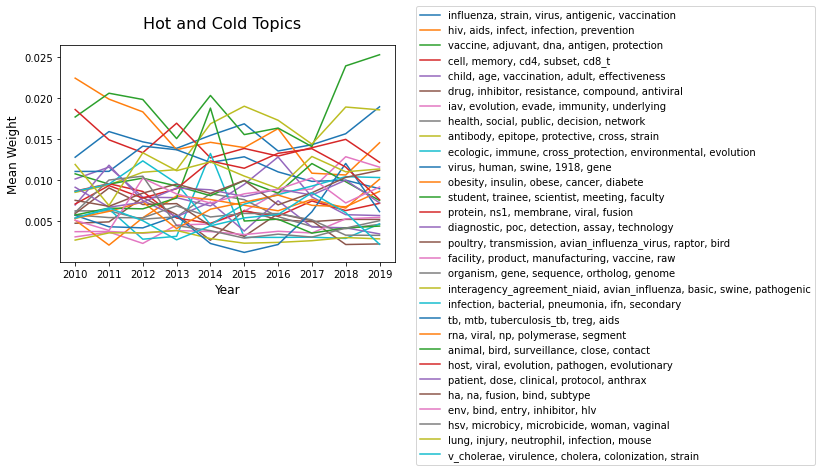

In [43]:
#Make Graphs
#leg = []
topic_results = {}
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    topic_results[i] = linear_fit.coef_[0][0]
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,i])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [44]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


In [45]:
# {column index, slope} - ex) 1: Topic 0 because Topic 0 is column 1 in the dataframe

#topic_results

In [46]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [47]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:5]]
bottom_slopes = [x[0] for x in sort_slopes[-5:]]

In [48]:
sort_slopes[:5]

[(9, 0.0011776396542913228),
 (7, 0.001136279579902201),
 (12, 0.0004942847793115481),
 (27, 0.00038141146588706906),
 (24, 0.0003800468963040989)]

In [49]:
top_slopes

[9, 7, 12, 27, 24]

In [50]:
bottom_slopes

[23, 28, 16, 15, 2]

### plot hottest and coldest on same plot

In [51]:
# for plotting hot and cold on same graph

topnbot_slopes = top_slopes + bottom_slopes

In [52]:
topnbot_slopes

[9, 7, 12, 27, 24, 23, 28, 16, 15, 2]

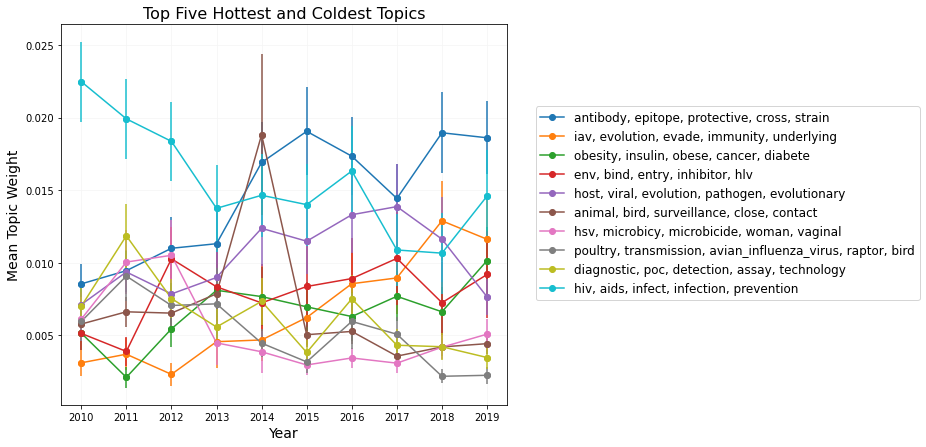

In [53]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in topnbot_slopes:
    zorder = 20
    color = color_list[i] 
    #if i < 5:
    #    zorder = 10 #10
    #    color = "#D3D3D3";
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in topnbot_slopes], handler_map={type(line_return[0]): HandlerDashedLines()})
           #handlelength=2, bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')  #handleheight=2,

plt.legend([leg[x-1] for x in topnbot_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/updated_full_hot_cold_topics.png", dpi = 800, bbox_inches = "tight")
plt.show()


### Plot hottest and coldest topics on separate plots

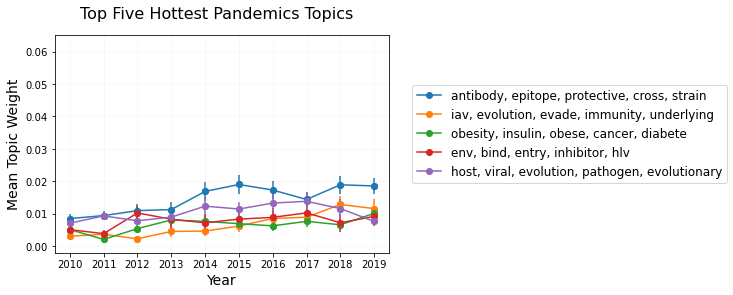

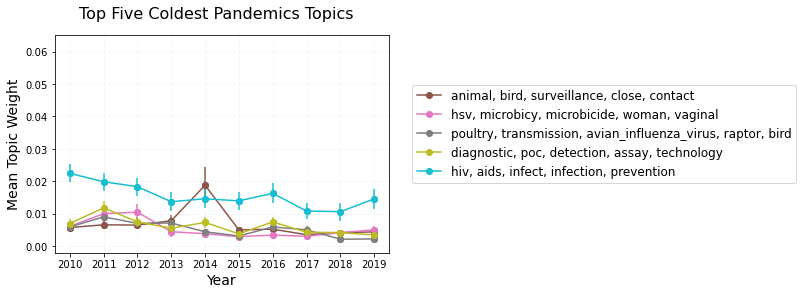

In [54]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]
#color_list = ["#D3D3D3","#2c4f6b","#C0C0C0","#A9A9A9","#808080","#D3D3D3","#2c4f6b","#D3D3D3","#D3D3D3", "#D3D3D3"] #"#fdfdfd"]


line_return = []
fig = plt.figure()
fig.suptitle('Top Five Hottest Pandemics Topics', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in top_slopes:
    zorder = 10
    color = color_list[i] # "#D3D3D3"   
    if i == 0:
        zorder = 10 #20
        color = color_list[i];
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in top_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/coronavirus_hot_topics-new.png", dpi = 800, bbox_inches = "tight")
plt.show()


#Make Graphs
#leg = []

#bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top Five Coldest Pandemics Topics', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
i = 0
for n in bottom_slopes:
    zorder = 10
    color = color_list[i+5]  #"#D3D3D3"  
    if i == 4:
        zorder = 10 #20
        color = color_list[i+5]
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color=color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color=color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)


# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in bottom_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/coronavirus_cold_topics-new.png", dpi = 800, bbox_inches = "tight")
plt.show()


### create plot for specific topics

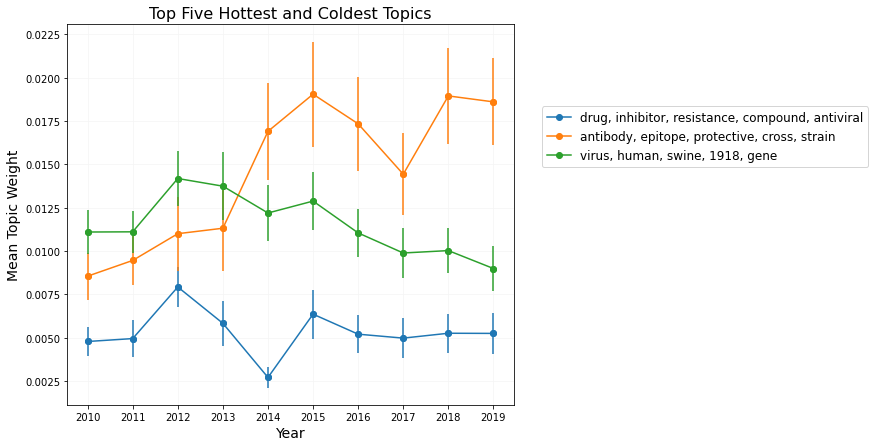

In [55]:
# Create plots for data stories in ET paper - topic numbers: 5, 8, 10 + 1 due to year being column 1

topic_idx = [6, 9, 11]

# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in topic_idx:
    zorder = 20
    color = color_list[i] 
    #if i < 5:
    #    zorder = 10 #10
    #    color = "#D3D3D3";
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in topic_idx], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in topic_idx], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/case-study.png", dpi = 800, bbox_inches = "tight")
plt.show()


## Plot for each topic in a grid

In [56]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 1 to 30

# leg: indices 0-29

[9,
 7,
 12,
 27,
 24,
 3,
 21,
 1,
 26,
 22,
 17,
 29,
 25,
 20,
 30,
 6,
 19,
 13,
 8,
 14,
 10,
 18,
 11,
 5,
 4,
 23,
 28,
 16,
 15,
 2]

In [75]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx] + ' \n' + title[idx:])
    
    

In [76]:
new_leg

['influenza, strain, virus, \n antigenic, vaccination',
 'hiv, aids, infect, \n infection, prevention',
 'vaccine, adjuvant, dna, \n antigen, protection',
 'cell, memory, cd4, \n subset, cd8_t',
 'child, age, vaccination, \n adult, effectiveness',
 'drug, inhibitor, resistance, \n compound, antiviral',
 'iav, evolution, evade, \n immunity, underlying',
 'health, social, public, \n decision, network',
 'antibody, epitope, protective, \n cross, strain',
 'ecologic, immune, cross_protection, \n environmental, evolution',
 'virus, human, swine, \n 1918, gene',
 'obesity, insulin, obese, \n cancer, diabete',
 'student, trainee, scientist, \n meeting, faculty',
 'protein, ns1, membrane, \n viral, fusion',
 'diagnostic, poc, detection, \n assay, technology',
 'poultry, transmission, avian_influenza_virus, \n raptor, bird',
 'facility, product, manufacturing, \n vaccine, raw',
 'organism, gene, sequence, \n ortholog, genome',
 'interagency_agreement_niaid, avian_influenza, basic, \n swine, pat

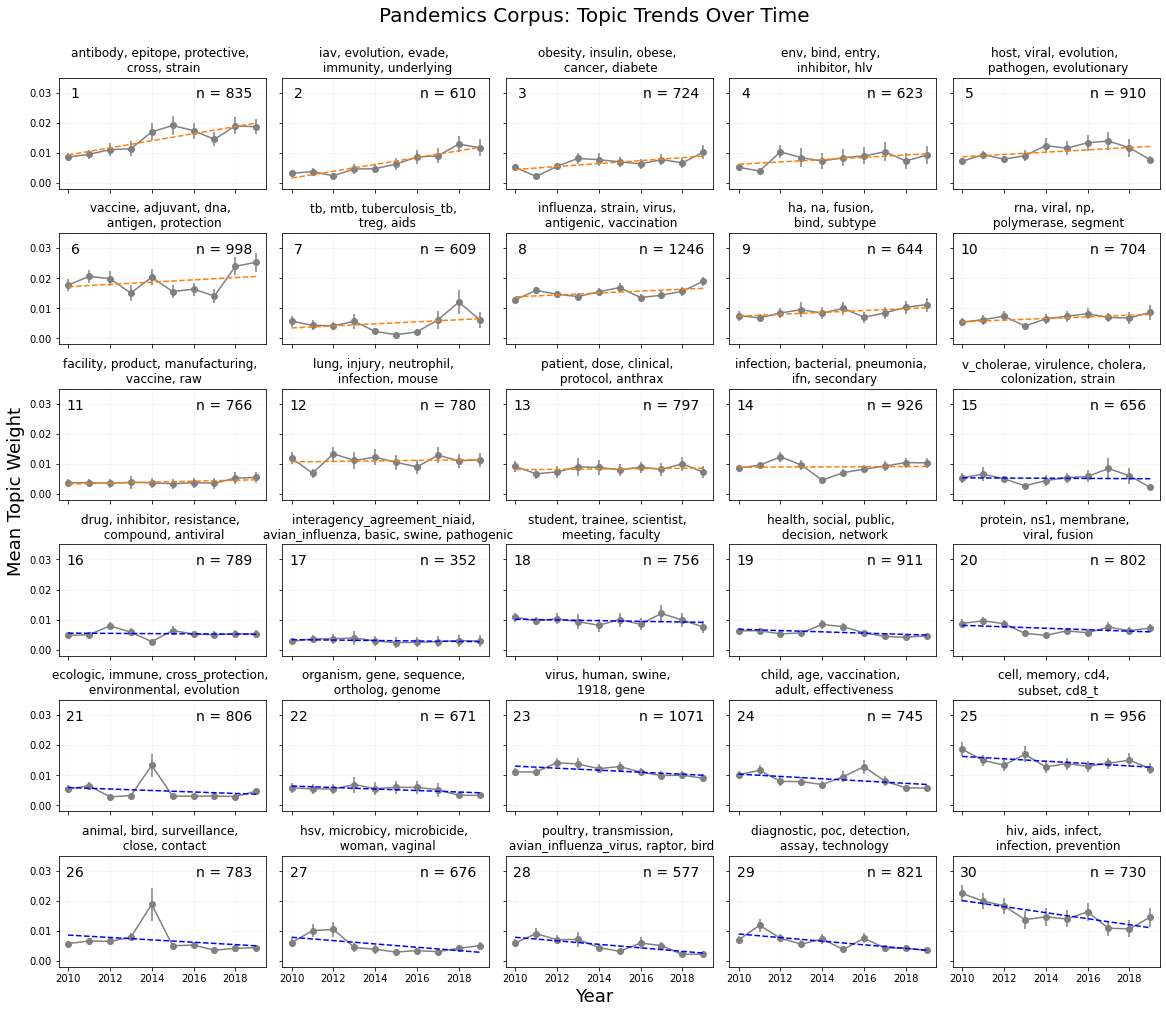

In [85]:
# set up grid
fig, ax = plt.subplots(6, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = -0.002, top = 0.035)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    if count == 16:
        ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
                          fontsize = 12)
    elif count == 27:
        ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    else:
        ax[i,j].set_title(new_leg[col_idx-1], fontsize = 12)
    
    # add topic number to each plot
    ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.80, 0.85, "n = " + str(n_by_topic[col_idx-1]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Pandemics Corpus: Topic Trends Over Time', fontsize = 20)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 18)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
fig.subplots_adjust(top=0.91)

plt.savefig("figures/pandemics/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

In [79]:
# get legend items for too long titles (topic 2)

new_leg[sorted_slopes[16]-1]
new_leg[sorted_slopes[27]-1]


'poultry, transmission, avian_influenza_virus, \n raptor, bird'

#### try other ways to show topic prevalence, number of projects, project costs

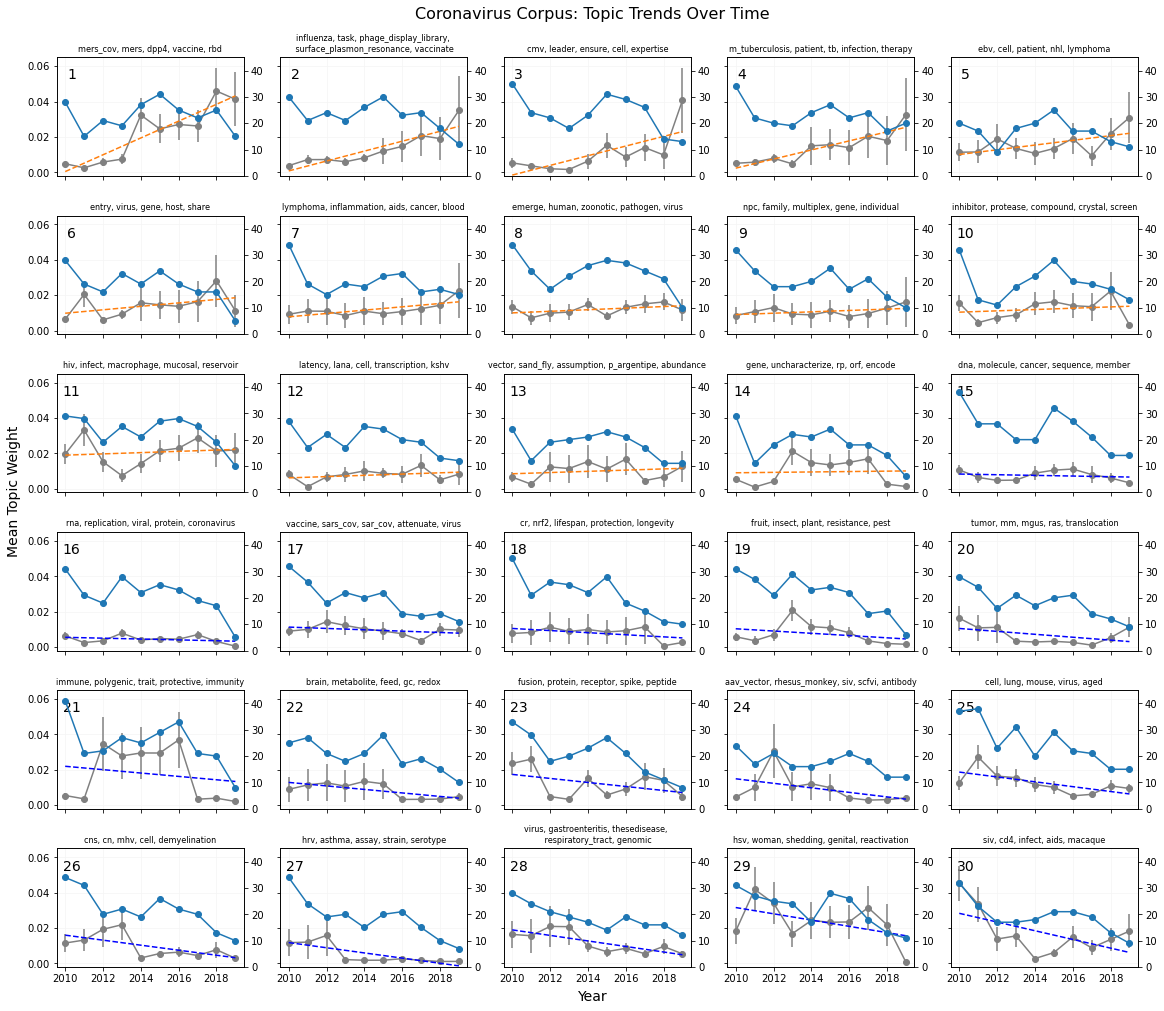

In [54]:
# dual axis approach

# set up grid
fig, ax = plt.subplots(6, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = -0.002, top = 0.065)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # try dual axis
    ax2 = ax[i,j].twinx()
    ax2.plot(topic_wts_2010_2019["START_YEAR"], topic_counts_filt[col], '-o')
    ax2.set_ylim(0,45)
    

    # put legend on two lines for topics 2, 28
    if count == 1:
        ax[i,j].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[i,j].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

#plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

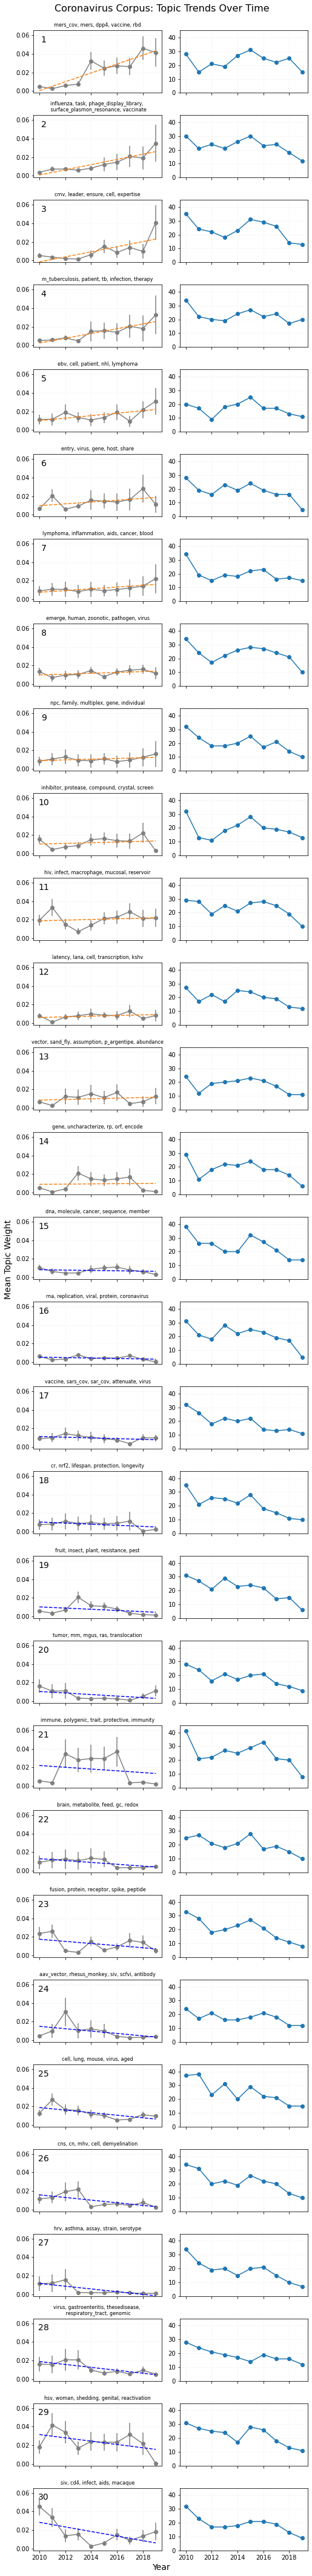

In [55]:
# try with multiple graphs per topic

# set up grid
fig, ax = plt.subplots(30, 2, sharex = True, sharey = 'col', figsize=(7,60))
#plt.ylim(bottom = -0.002, top = 0.065)

# create plots for each row
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # 1: mean topic weights plot
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[count,0].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[count,0].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[count,0].grid(color = "whitesmoke")
    
    # put title on two lines for topics 2, 28
    if count == 1:
        ax[count,0].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[count,0].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[count,0].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[count,0].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[count,0].transAxes, fontsize = 14)
    
    ax[count,0].set_ylim(-0.002,0.065)
    
    # 2. Number of projects plot

    ax[count,1].plot(topic_wts_2010_2019["START_YEAR"], topic_counts_filt[col], '-o')
    ax[count,1].set_ylim(0,45)
    ax[count,1].grid(color = "whitesmoke")
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, 0, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.97)

#plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

### Descriptive statistics on corpus

In [59]:
df["START_YEAR"].value_counts()

2009    299
2011    286
2010    274
2012    237
2008    220
2016    199
2014    196
2015    192
2017    176
2018    169
2019    161
2013    156
2007    133
2006     66
2003     52
2005     41
2004     31
2001     19
1999     15
2002     14
1998      9
1997      8
1993      8
1990      6
1991      5
2000      5
1983      4
1987      4
1992      3
1981      3
1977      3
1994      3
1989      3
1996      2
1995      1
2020      1
1980      1
1979      1
Name: START_YEAR, dtype: int64

In [60]:
df["DEPARTMENT"].value_counts()

HHS     2810
NSF       99
USDA      68
DOD       20
VA         6
NASA       2
EPA        1
Name: DEPARTMENT, dtype: int64

In [61]:
# filter data frame by year and repeat descriptive statistics.  Limit years to those for emerging topic analysis.

filt_df = df.copy()
filt_df["START_YEAR"] = filt_df["START_YEAR"].astype('int')

filt_df = filt_df[filt_df["START_YEAR"] > 2009]
filt_df = filt_df[filt_df["START_YEAR"] < 2020]

In [62]:
filt_df["START_YEAR"].value_counts().sort_index()
#filt_df["START_YEAR"].value_counts().sort_index().values

2010    274
2011    286
2012    237
2013    156
2014    196
2015    192
2016    199
2017    176
2018    169
2019    161
Name: START_YEAR, dtype: int64

In [63]:
filt_df["DEPARTMENT"].value_counts()

HHS     1901
NSF       72
USDA      47
DOD       20
VA         4
NASA       1
EPA        1
Name: DEPARTMENT, dtype: int64

In [64]:
filt_df.pivot_table(index=['DEPARTMENT','START_YEAR'], aggfunc='size')

DEPARTMENT  START_YEAR
DOD         2010            1
            2015            2
            2016            1
            2017            3
            2018           10
            2019            3
EPA         2015            1
HHS         2010          253
            2011          259
            2012          223
            2013          143
            2014          185
            2015          175
            2016          184
            2017          164
            2018          157
            2019          158
NASA        2011            1
NSF         2010           12
            2011            9
            2012            9
            2013            6
            2014            6
            2015           12
            2016            8
            2017            8
            2018            2
USDA        2010            8
            2011           17
            2012            5
            2013            5
            2014            4
            2015 

In [65]:
filt_df.shape

(2046, 42)